In [1]:
import scanpy as sc
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import anndata2ri
import logging
from scipy.sparse import issparse
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sc.settings.verbosity = 0
sc.settings.set_figure_params(
dpi=80,
facecolor="white",
frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/tmp/ipykernel_44/2014537900.py:20: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [2]:
adata = sc.read(
filename="s4d8_quality_control.h5ad",
backup_url="https://figshare.com/ndownloader/files/40014331",
)

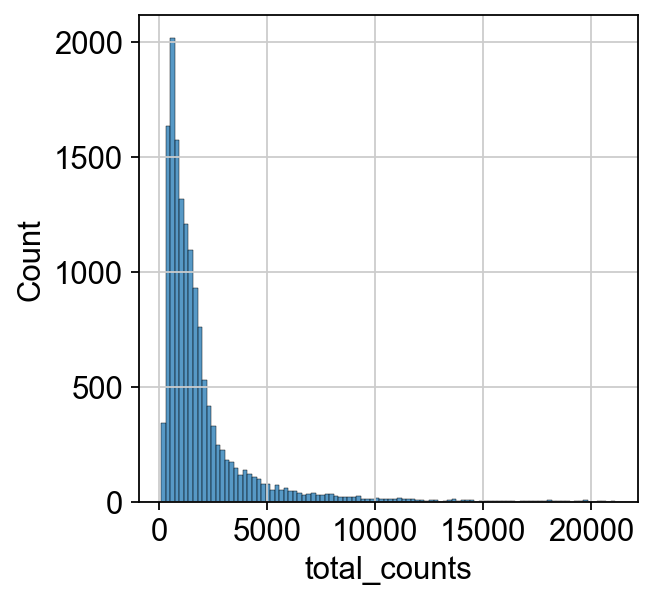

In [3]:
p1 = sns.histplot(adata.obs['total_counts'], bins=100, kde=False)

In [4]:
scaled_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.layers['log1p_norm'] = sc.pp.log1p(scaled_counts['X'], copy=True)

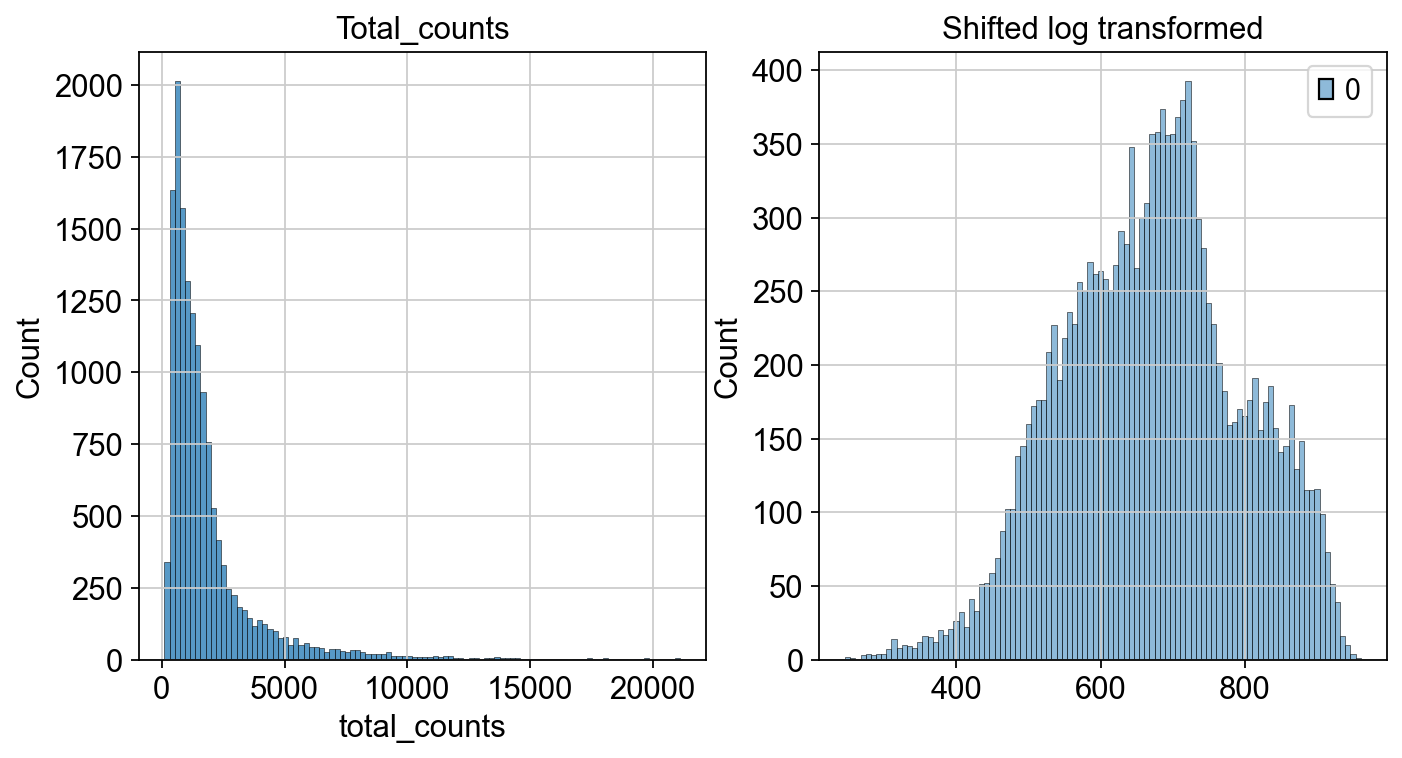

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs['total_counts'], bins=100, kde=False, ax=axes[0])
axes[0].set_title('Total_counts')
p2 = sns.histplot(adata.layers['log1p_norm'].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title('Shifted log transformed')
plt.show()

In [6]:
from scipy.sparse import csr_matrix, issparse

In [7]:
%%R
library(scran)
library(BiocParallel)

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOr

In [8]:
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added='groups')
input_groups = adata_pp.obs['groups']

/tmp/ipykernel_44/1236457903.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_pp, key_added='groups')


In [9]:
data_mat = adata_pp.X.T
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
else:
    print("data_mat is not a sparse matrix")

In [10]:
del adata_pp

In [11]:
%%R -o size_factors -i data_mat -i input_groups

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)
        ),
        clusters = input_groups,
        min.mean = 0.1,
        BPPARAM = MulticoreParam()
    )
)

In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
2: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


In [12]:
adata.obs['size_factors'] = size_factors
scran = adata.X / adata.obs['size_factors'].values[:,None]
adata.layers['scran_normalized'] = csr_matrix(sc.pp.log1p(scran))

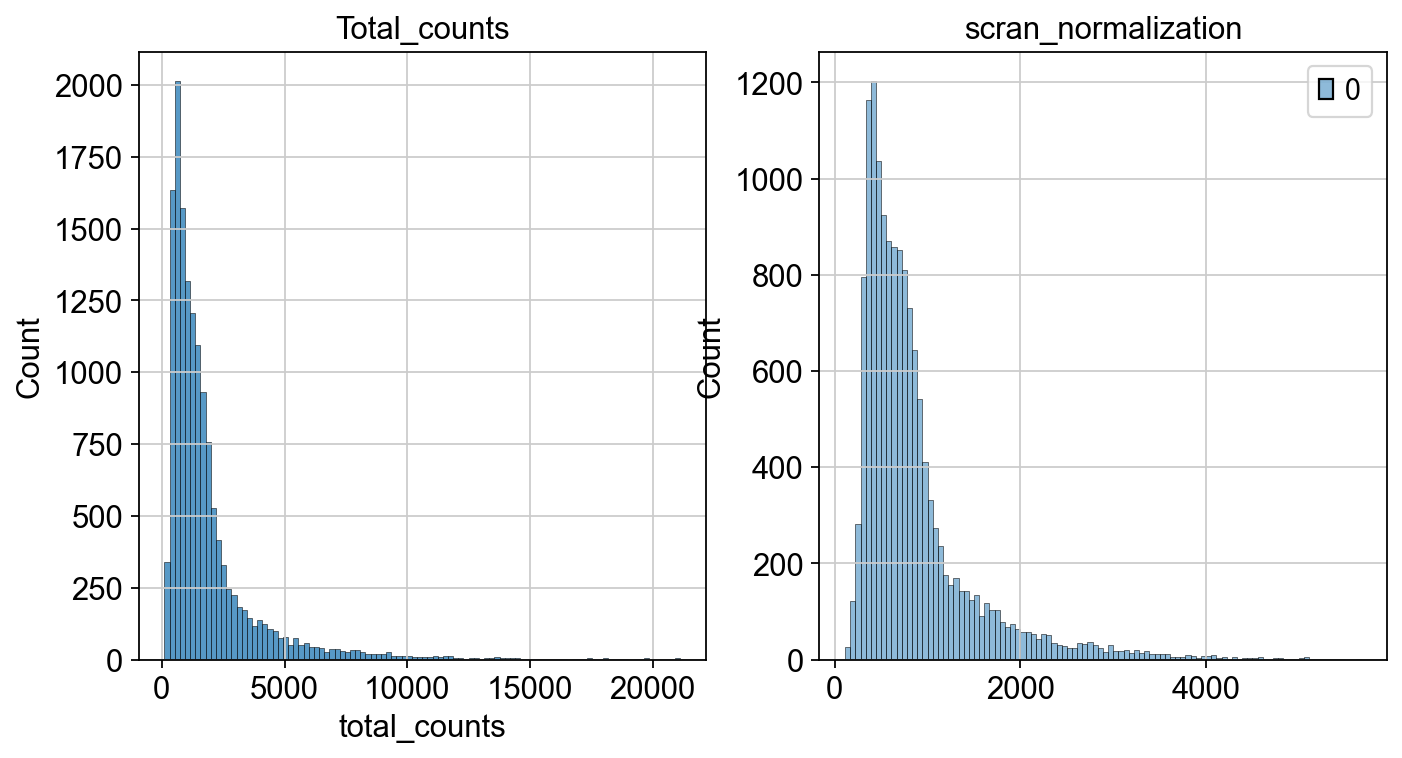

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs['total_counts'], bins=100, kde=False, ax=axes[0])
axes[0].set_title('Total_counts')
p2 = sns.histplot(adata.layers['scran_normalized'].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title('scran_normalization')
plt.show()

In [4]:
pearson_residues = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)

In [ ]:
adata.layers['analytic_pearson_residues'] = csr_matrix(pearson_residues['X'])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs['total_counts'], bins=100, kde=False, ax=axes[0])
axes[0].set_title('Total_counts')
p2 = sns.histplot(adata.layers['analytic_pearson_residues'].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title('analytic_pearson_residues')
plt.show()

In [14]:
adata.write("s4d8_normalization.h5ad")
# pearson residues not added